# **ETF Forecasting**

The following data set has been provided by BORIS MARJANOVIC on Kaggle. He has allowed free use of the data for personal use. The link to complete data set : https://www.kaggle.com/datasets/borismarjanovic/price-volume-data-for-all-us-stocks-etfs/data

We will be using several machine learning algorithms along with statistical methods to train and test out model. We begin by importing all the necessary libraries for this project. 

In [61]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

For this project, we will be creating an **ETF** class that encapsulates all the necessary methods to analyze, modify, and train data models on ETF (Exchange-Traded Fund) data. The class provides functionalities for reading the data, cleaning it, generating descriptive statistics, plotting various financial metrics, and building a linear regression model to predict the closing prices. 

*Note that we are creating a class because all the datasets have same strucutre and heence would have same preprocessing and analysis. In case of a dataset with different structure, we would have to manually clean and  preprocess that data*

## **Overview of the ETF Class**

- **Initialization**:
  - The class is initialized with the name of the ETF, which is used to load the corresponding data file.

- **Methods**:
  - **read_etfs**: Reads the ETF data from a CSV file and loads it into a pandas DataFrame.

  - **describe**: Provides detailed information about the DataFrame, including its structure, statistics, and any missing values.

  - **clean**: Cleans the data by converting the date column, dropping unnecessary columns, and adjusting the volume data for better readability.

  - **plot_folder**: Creates a directory structure to save plots for the ETF.

  - **plot_open_price**, **plot_close_price**, **plot_highs**, **plot_lows**, **plot_volume**: These methods individually handle the creation and saving of line and bar plots for different financial metrics (open price, close price, highs, lows, and volume) over time.

  - **plot_series** and **plot_bar**: Handle the creation of line and bar plots for different financial metrics over time.

  - **ml_preprocess**: Prepares the data for machine learning by adding new features such as day, month, and year extracted from the date.
  
  - **linearModel**: Builds and trains a linear regression model to predict the closing price of the ETF based on several features, and calculates the Mean Squared Error (MSE) and R² score for model evaluation.

With this class, we can efficiently perform a wide range of operations on ETF data, from basic exploratory data analysis to more advanced predictive modeling.

In [62]:
class ETF:
    def __init__(self, name):
        self.name = name
        self.df = self.read_etfs()
        self.cleaned_df = None
        self.r2Score = None
        self.mse = None

    def read_etfs(self) -> pd.DataFrame:
        df = pd.read_csv(f"./Data/ETFs/{self.name}.us.txt")
        return df

    def describe(self, df: pd.DataFrame):
        print("DataFrame Information:")
        df.info()
        
        print("\nDescriptive Statistics:")
        print(df.describe())
        
        print("\nFirst 5 Rows:")
        print(df.head())
        
        print("\nLast 5 Rows:")
        print(df.tail())
        
        print("\nDataFrame Shape (rows, columns):")
        print(df.shape)
        
        print("\nRandom Sample of 5 Rows:")
        print(df.sample(5))
        
        print("\nMissing Values Count per Column:")
        print(df.isnull().sum())
        print()

    def clean(self) -> pd.DataFrame:
        df = self.df.copy()
        df["Date"] = pd.to_datetime(df["Date"])
        df = df.drop("OpenInt", axis=1)
        df["Volume"] = df["Volume"] / 10**7
        df = df.rename(columns={"Volume": "Volume in Millions"})
        self.cleaned_df = df
        return df

    def plot_folder(self):
        if not os.path.exists(f"./Plots/ETFs/{self.name}"):
            os.makedirs(f"./Plots/ETFs/{self.name}")
        return

    def plot_open_price(self):
        if self.cleaned_df is None:
            raise ValueError("Data is not cleaned before plotting.")
        self.plot_folder()
        self.plot_series(self.cleaned_df, 'Open', 'Open Price')

    def plot_close_price(self):
        if self.cleaned_df is None:
            raise ValueError("Data is not cleaned before plotting.")
        self.plot_folder()
        self.plot_series(self.cleaned_df, 'Close', 'Close Price')

    def plot_highs(self):
        if self.cleaned_df is None:
            raise ValueError("Data is not cleaned before plotting.")
        self.plot_folder()
        self.plot_series(self.cleaned_df, 'High', 'Highs')

    def plot_lows(self):
        if self.cleaned_df is None:
            raise ValueError("Data is not cleaned before plotting.")
        self.plot_folder()
        self.plot_series(self.cleaned_df, 'Low', 'Lows')

    def plot_volume(self):
        if self.cleaned_df is None:
            raise ValueError("Data is not cleaned before plotting.")
        self.plot_folder()
        self.plot_bar(self.cleaned_df, 'Volume in Millions', 'Volume')

    def plot_series(self, df, column, title):
        plt.figure(figsize=(8, 5))
        plt.plot(df["Date"], df[column], color='royalblue', linestyle='-', linewidth=1, label=title)
        plt.title(f'ETF {title}', fontsize=16)
        plt.xlabel('Date', fontsize=14)
        plt.ylabel(title, fontsize=14)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.savefig(f"./Plots/ETFs/{self.name}/{title}.png")

    def plot_bar(self, df, column, title):
        plt.figure(figsize=(8, 5))
        plt.bar(df["Date"], df[column], color='royalblue', label=title)
        plt.title(f'ETF {title}', fontsize=16)
        plt.xlabel('Date', fontsize=14)
        plt.ylabel(title, fontsize=14)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.savefig(f"./Plots/ETFs/{self.name}/{title}.png")

    def expand(self, df):
        df["Daily Return"] = (df["Close"] - df["Open"]) / df["Open"] * 100

        df["20-Day MA"] = df["Close"].rolling(window=20).mean()
        df["50-Day MA"] = df["Close"].rolling(window=50).mean()
        df["200-Day MA"] = df["Close"].rolling(window=200).mean()
        df["30-Day Volatility"] = df["Daily Return"].rolling(window=30).std()

        delta = df["Close"].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        rs = gain / loss
        df["RSI"] = 100 - (100 / (1 + rs))

        df["Middle Band"] = df["20-Day MA"]
        df["Upper Band"] = df["Middle Band"] + (2 * df["Close"].rolling(window=20).std())
        df["Lower Band"] = df["Middle Band"] - (2 * df["Close"].rolling(window=20).std())

        df["Cumulative Return"] = (df["Close"] / df["Close"].iloc[0]) - 1

        df["VWAP"] = (df["Volume in Millions"] * df["Close"]).cumsum() / df["Volume in Millions"].cumsum()

        

    def ml_preprocess(self) -> pd.DataFrame:
        df = self.cleaned_df.copy()
        df["Date"] = pd.to_datetime(df["Date"])
        df["Day"] = df["Date"].dt.dayofweek
        df["Month"] = df["Date"].dt.month
        df["Year"] = df["Date"].dt.year
        return df

    def linearModel(self):
        if self.cleaned_df is None:
            raise ValueError("Data must be cleaned before processing.")
        
        df = self.ml_preprocess()
        features = ['Open', 'High', 'Low', 'Volume in Millions', 'Day', 'Month', 'Year']
        target = 'Close'
        X = df[features]
        Y = df[target]
        trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.2, shuffle=False)
        model = LinearRegression()
        model.fit(trainX, trainY)
        predY = model.predict(testX)
        self.mse = mean_squared_error(testY, predY)
        self.r2Score = r2_score(testY, predY)

## **Analysis**

Now the class is ready to be called. We can see the various results that the analysis will give us. For the purpose of this project we will be using the historic data of **QQQ (Invesco QQQ Trust, Series 1)**. We begin by assigning the ticker as the default value. For analysis of other datasets, the input statement can be used to take input from the user.

In [63]:
# ticker = input("Enter the ticker: ").strip().lower()
ticker = "qqq"
etf = ETF(ticker)

Now we use the **describe** method for the ETF class to describe the data set we have.

In [64]:
etf.describe(etf.df)

DataFrame Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4701 entries, 0 to 4700
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Date     4701 non-null   object 
 1   Open     4701 non-null   float64
 2   High     4701 non-null   float64
 3   Low      4701 non-null   float64
 4   Close    4701 non-null   float64
 5   Volume   4701 non-null   int64  
 6   OpenInt  4701 non-null   int64  
dtypes: float64(4), int64(2), object(1)
memory usage: 257.2+ KB

Descriptive Statistics:
              Open         High          Low        Close        Volume  \
count  4701.000000  4701.000000  4701.000000  4701.000000  4.701000e+03   
mean     58.398648    58.888507    57.837278    58.386467  8.054378e+07   
std      31.211635    31.316778    31.071677    31.220362  5.903922e+07   
min      17.830000    18.361000    17.665000    17.938000  5.828392e+06   
25%      34.904000    35.173000    34.559000    34.876000  3.4477

We can see that there are 7 columns in the dataset with Date beign reffered as an object data type. There are total of 4701 records and the last cloumn **OpenInt** has all the records set to zero. There are no missing values in any column, which is extremely good. Now we will clean and preprocess the data for plotting some basic charts, to gain more insight.

## **Data Cleaning**

In [65]:
etf.clean()
etf.describe(etf.cleaned_df)

DataFrame Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4701 entries, 0 to 4700
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                4701 non-null   datetime64[ns]
 1   Open                4701 non-null   float64       
 2   High                4701 non-null   float64       
 3   Low                 4701 non-null   float64       
 4   Close               4701 non-null   float64       
 5   Volume in Millions  4701 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 220.5 KB

Descriptive Statistics:
                                Date         Open         High          Low  \
count                           4701  4701.000000  4701.000000  4701.000000   
mean   2008-07-12 15:48:21.595405568    58.398648    58.888507    57.837278   
min              1999-03-10 00:00:00    17.830000    18.361000    17.665000   
25%              2003

As we can see, the **Date** column has been converted to *datetime64* object. For the sake of simplicity in plotting we have converted **Volume** column to **Volume in Millions**. This will help us plot the data on graph closer to measurable scale. Now we can move on to plot different plot and analyse them accordingly.

## **Data Visualization**

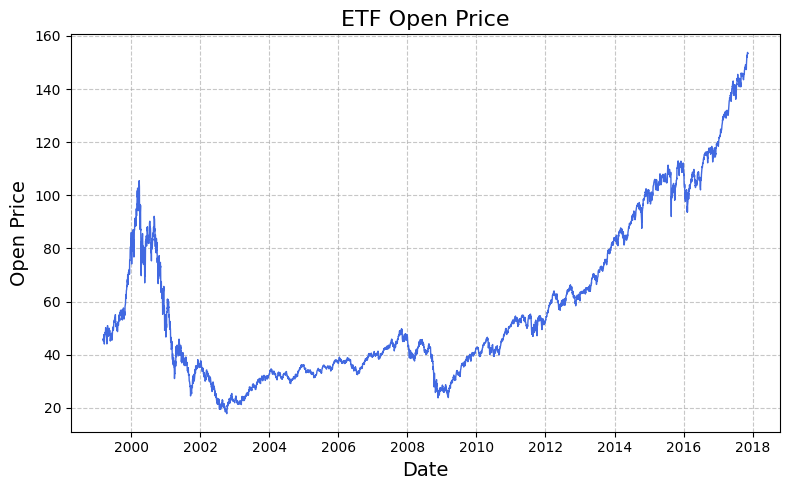

In [66]:
etf.plot_open_price()

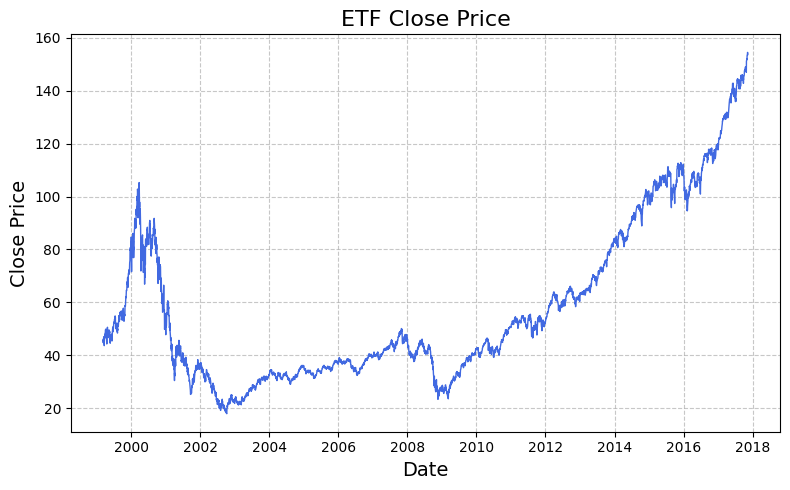

In [67]:
etf.plot_close_price()

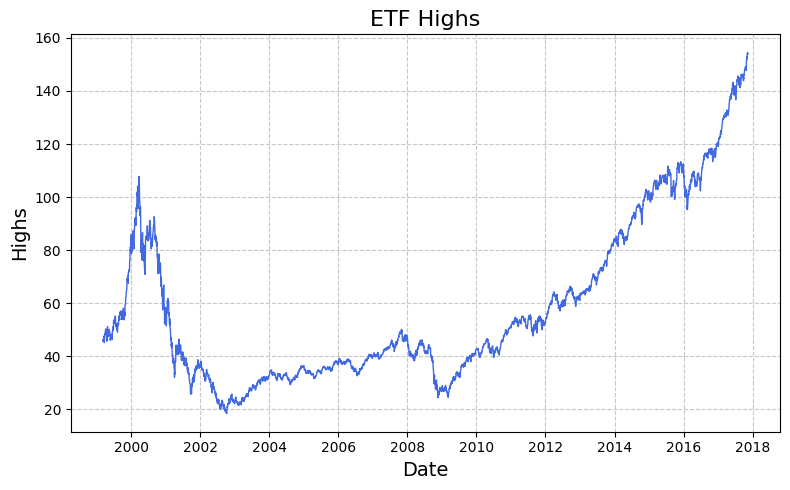

In [68]:
etf.plot_highs()

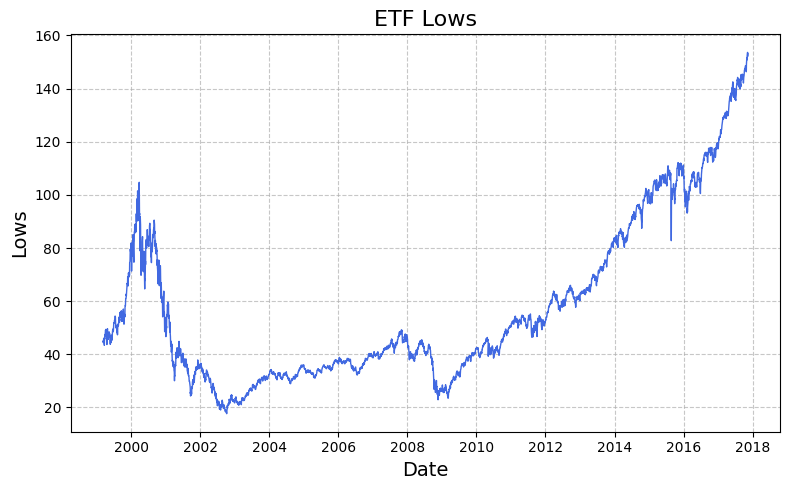

In [69]:
etf.plot_lows()

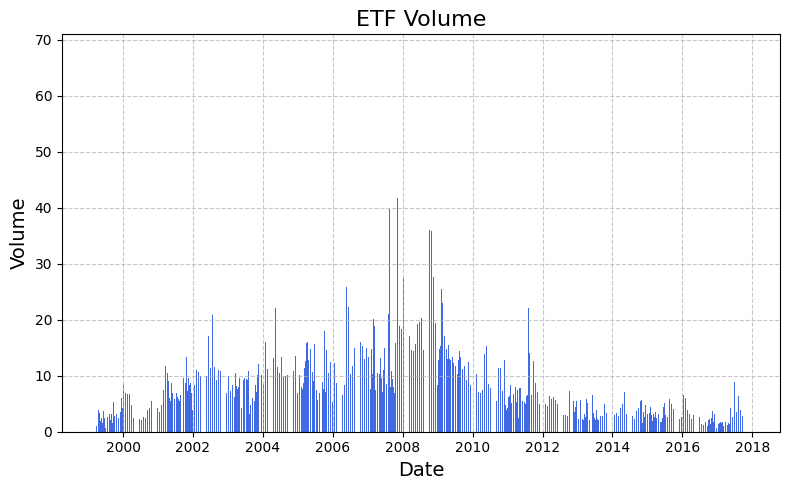

In [70]:
etf.plot_volume()

In [71]:
etf.expand()
etf.describe(etf.df)

KeyError: 'Volume in Millions'